### loading and preprocessing python dataset

In [9]:

import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

# Define the dataset class
class PetDataset(Dataset):
    def __init__(self, img_paths, bbox_coords, transform=None):
        self.img_paths = img_paths
        self.bbox_coords = bbox_coords
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(self.img_paths[index])
        bbox = self.bbox_coords[index]
        if self.transform:
            img = self.transform(img)
        return img, bbox

    def __len__(self):
        return len(self.img_paths)
    
# Define the transforms to apply to the images
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
])

# Load the image paths and bounding box coordinates
img_paths = 'data/images/'
bbox_coords = 'data/annotations/xmls/' # list of tuples containing the bounding box coordinates for each pet

# Create the dataset and dataloader
dataset = PetDataset(img_paths, bbox_coords, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

[(129, 146, 314, 321), (125, 68, 282, 236), (30, 81, 250, 343), (192, 63, 314, 176), (139, 106, 228, 216), (95, 161, 188, 239), (207, 6, 314, 112), (203, 118, 292, 217), (79, 42, 241, 232), (157, 13, 219, 69), (182, 95, 274, 171), (111, 14, 275, 254), (181, 1, 386, 173), (160, 176, 456, 357), (97, 21, 173, 102), (90, 209, 246, 357), (214, 67, 337, 217), (105, 30, 362, 286), (19, 32, 123, 129), (300, 2, 489, 204), (160, 21, 340, 230), (263, 67, 358, 164), (101, 22, 183, 122), (178, 127, 307, 294), (157, 56, 264, 116), (83, 29, 197, 142), (32, 18, 363, 369), (128, 22, 240, 222), (97, 35, 304, 199), (91, 1, 370, 332), (297, 28, 397, 120), (19, 24, 134, 111), (66, 60, 216, 201), (102, 28, 405, 297), (120, 11, 250, 150), (125, 12, 428, 344), (117, 1, 347, 251), (103, 36, 194, 120), (78, 66, 291, 227), (97, 78, 430, 454), (34, 80, 312, 319), (100, 91, 270, 202), (81, 52, 183, 163), (47, 103, 198, 224), (93, 16, 409, 327), (205, 127, 295, 211), (324, 69, 408, 161), (124, 13, 428, 249), (140, 

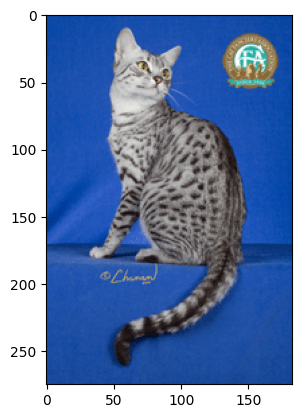

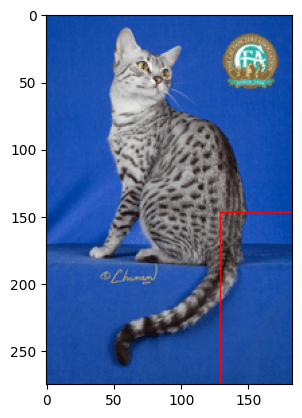

In [26]:
import os
import glob
import xml.etree.ElementTree as ET

# get all the images that have xml files
img_paths = glob.glob('data/images/*.jpg')
# img_paths = ['data/images/Abyssinian_1.jpg']

# get the bounding box coordinates from the xml files
bbox_coords = []
for img_path in img_paths:
    # print(img_path)
    xml_path = img_path.replace('.jpg', '.xml')
    # add data/annotations/xmls/ to the xml path instead of data/images/
    xml_path = xml_path.replace('images', 'annotations/xmls')
    # print(xml_path)
    if not os.path.exists(xml_path):
        continue  # skip images without xml
    root = ET.parse(xml_path).getroot()
    xmin = int(root.find('object').find('bndbox').find('xmin').text)
    ymin = int(root.find('object').find('bndbox').find('ymin').text)
    xmax = int(root.find('object').find('bndbox').find('xmax').text)
    ymax = int(root.find('object').find('bndbox').find('ymax').text)
    bbox_coords.append((xmin, ymin, xmax, ymax))

print(bbox_coords)

# visualize the bounding boxes
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# get the first image and bounding box coordinates
img = Image.open(img_paths[0])
xmin, ymin, xmax, ymax = bbox_coords[0]

# plot the image with the bounding box
fig, ax = plt.subplots(1)
ax.imshow(img)
fig, ax = plt.subplots(1)
ax.imshow(img)
rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.show()

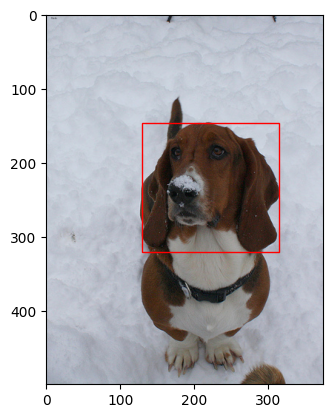

In [32]:
import os
import glob
import xml.etree.ElementTree as ET
from PIL import Image

# get all the images that have xml files
img_paths = glob.glob('data/images/*.jpg')

# create a dictionary to store the bounding box coordinates and images
bbox_dict = {}

# get the bounding box coordinates from the xml files
for img_path in img_paths:
    xml_path = img_path.replace('.jpg', '.xml')
    xml_path = xml_path.replace('images', 'annotations/xmls')
    if not os.path.exists(xml_path):
        continue  # skip images without xml
    root = ET.parse(xml_path).getroot()
    xmin = int(root.find('object').find('bndbox').find('xmin').text)
    ymin = int(root.find('object').find('bndbox').find('ymin').text)
    xmax = int(root.find('object').find('bndbox').find('xmax').text)
    ymax = int(root.find('object').find('bndbox').find('ymax').text)
    bbox_coords = (xmin, ymin, xmax, ymax)
    img = Image.open(img_path)
    bbox_dict[img_path] = {'bbox': bbox_coords, 'img': img}

# visualize the bounding boxes
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# get the first image and bounding box coordinates
img_path = list(bbox_dict.keys())[0]
img = bbox_dict[img_path]['img']
xmin, ymin, xmax, ymax = bbox_dict[img_path]['bbox']

# plot the image with the bounding box
fig, ax = plt.subplots(1)
ax.imshow(img)
rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.show()

## model to predict bboxes

In [1]:
import tensorflow as tf
import numpy as np
import os
import glob
import xml.etree.ElementTree as ET
from PIL import Image

# define the target image size
img_size = (224, 224)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=img_size + (3,)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4)
])

model.compile(optimizer='adam', loss='mse')

# get all the images that have xml files
img_paths = glob.glob('data/images/*.jpg')

# create a list to store the bounding box coordinates and images
data = []

# get the bounding box coordinates from the xml files
for img_path in img_paths:
    xml_path = img_path.replace('.jpg', '.xml')
    xml_path = xml_path.replace('images', 'annotations/xmls')
    if not os.path.exists(xml_path):
        continue  # skip images without xml
    root = ET.parse(xml_path).getroot()
    xmin = int(root.find('object').find('bndbox').find('xmin').text)
    ymin = int(root.find('object').find('bndbox').find('ymin').text)
    xmax = int(root.find('object').find('bndbox').find('xmax').text)
    ymax = int(root.find('object').find('bndbox').find('ymax').text)
    bbox_coords = (xmin, ymin, xmax, ymax)
    with Image.open(img_path) as img:
        # resize the image to the target size and convert to a numpy array
        img = img.resize(img_size)
        img_arr = np.array(img)
        # normalize the pixel values to be between 0 and 1
        img_arr = img_arr / 255.0
        # make sure the image has 3 channels (in case it's grayscale)
        if len(img_arr.shape) == 2:
            img_arr = np.stack([img_arr] * 3, axis=-1)
        data.append({'img': img_arr, 'bbox': bbox_coords})

# convert the data into numpy arrays
X = np.array([d['img'] for d in data])
y = np.array([d['bbox'] for d in data])

# train the model
model.fit(X, y, epochs=10)

# save the model
model.save('object_detection_model')


2023-04-12 20:13:05.333852: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
116/116 [==============================] - 165s 1s/step - loss: 12211.9883
Epoch 2/10
116/116 [==============================] - 249s 2s/step - loss: 9003.8379
Epoch 3/10
 50/116 [===========>..................] - ETA: 2:12 - loss: 8772.2002

KeyboardInterrupt: 

In [ ]:
data

Epoch 1/10
93/93 [==============================] - 35s 372ms/step - loss: 7407.7417 - val_loss: 7269.7539
Epoch 2/10
93/93 [==============================] - 30s 326ms/step - loss: 7297.8848 - val_loss: 7180.1455
Epoch 3/10
93/93 [==============================] - 29s 314ms/step - loss: 7061.5850 - val_loss: 7204.8618
Epoch 4/10
93/93 [==============================] - 33s 356ms/step - loss: 7122.7192 - val_loss: 7299.9805
Epoch 5/10
93/93 [==============================] - 29s 309ms/step - loss: 7087.2490 - val_loss: 7668.2817
Epoch 6/10
93/93 [==============================] - 29s 309ms/step - loss: 7059.7729 - val_loss: 7270.2827
Epoch 7/10
93/93 [==============================] - 30s 324ms/step - loss: 6652.1240 - val_loss: 7141.4824
Epoch 8/10
93/93 [==============================] - 29s 308ms/step - loss: 6719.4038 - val_loss: 7198.5894
Epoch 9/10
93/93 [==============================] - 29s 308ms/step - loss: 6711.6567 - val_loss: 7223.0415
Epoch 10/10
93/93 [==================

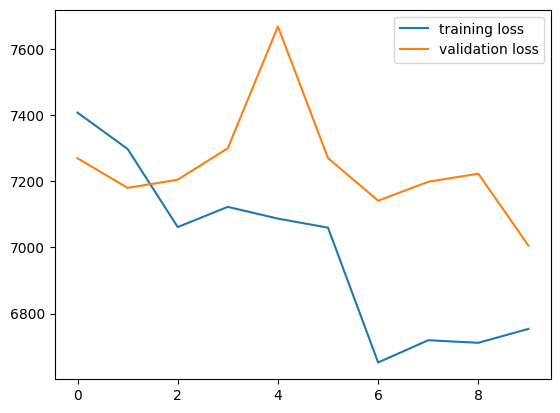

In [56]:
# split the data into a training set and a validation set
split_idx = int(0.8 * len(data))
train_data = data[:split_idx]
val_data = data[split_idx:]

# convert the data into numpy arrays
X_train = np.array([d['img'] for d in train_data])
y_train = np.array([d['bbox'] for d in train_data])
X_val = np.array([d['img'] for d in val_data])
y_val = np.array([d['bbox'] for d in val_data])

# train the model on the training set, and evaluate its performance on the validation set
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# plot the training and validation loss curves
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()


1/1 [==============================] - 0s 439ms/step


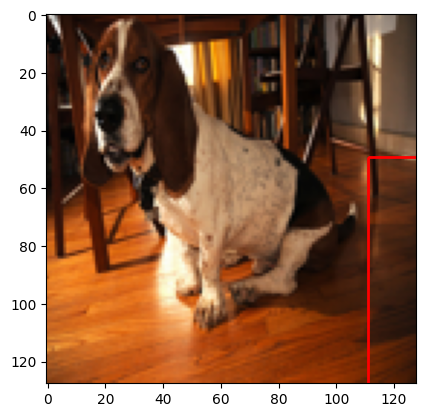

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow import keras

# load the model
model = keras.models.load_model('object_detection_model')

# define the target image size
img_size = (224, 224)

# try out the model on a new image
img_path = 'data/images/basset_hound_15.jpg'
with Image.open(img_path) as img:
    # resize the image to the target size
    img = img.resize(img_size)
    # convert the image to a numpy array
    img_arr = np.array(img)
    # normalize the pixel values to be between 0 and 1
    img_arr = img_arr / 255.0
    # make sure the image has 3 channels (in case it's grayscale)
    if len(img_arr.shape) == 2:
        img_arr = np.stack([img_arr] * 3, axis=-1)
    # make a prediction on the image
    y_pred = model.predict(np.array([img_arr]))
    # get the predicted bounding box coordinates
    xmin, ymin, xmax, ymax = y_pred[0].astype(int)
    # plot the image
    plt.imshow(img_arr)
    # create a rectangle patch for the bounding box
    rect = plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=2, edgecolor='r', facecolor='none')
    # add the patch to the plot
    ax = plt.gca()
    ax.add_patch(rect)
    # show the plot
    plt.show()


In [77]:
y_pred

array([[111.52601 ,  49.216785, 280.14868 , 212.68619 ]], dtype=float32)